In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random

from matplotlib.colors import ListedColormap

import mlrfit as mf
import mfmodel as mfm

In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 100000
signal_to_noise = 4



L = 5

# ranks = np.array([5, 4, 3, 2, 1])
ranks = np.array([30, 20, 10, 5, 1])
rank = ranks.sum()

nsamples = rank * 4
nsamples

264

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], 3)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=100000.0
level=1, num_groups=3, mean_size=33333.3
level=2, num_groups=6, mean_size=16666.7
level=3, num_groups=16, mean_size=6250.0
level=4, num_groups=100000, mean_size=1.0


In [5]:
F_hpart = {"pi": hpart['rows']["pi"], "lk": hpart['rows']["lk"][:-1]}
true_mfm = mfm.MFModel()
true_mfm = mfm.generate_mfmodel(true_mfm, n, F_hpart, ranks, signal_to_noise, debug=False)
F_hpart["pi_inv"] = true_mfm.pi_inv

signal_var=81.15506713197232, noise_var=16.242432778950498
SNR=3.9964847160793444, signal_to_noise=4


(100000, 230)


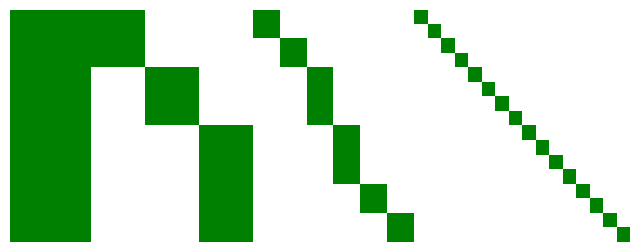

In [6]:
true_sparse_F = mf.convert_compressed_to_sparse(true_mfm.F, 
                                             F_hpart, 
                                             ranks[:-1]).toarray()
print(true_sparse_F.shape)
cmap = ListedColormap(['white', 'green'])
plt.figure(figsize=(8, 3)) 
plt.matshow(true_sparse_F!=0, aspect='auto', fignum=1, cmap=cmap) 
plt.axis('off')
# plt.show()

# Save the figure to a PDF file
plt.savefig('large_F_sparsity.pdf', bbox_inches='tight', pad_inches=0)
# plt.close()
del true_sparse_F

In [7]:
n * n * 4 * 2 / 2**30, n * n * 4 / 2**30

(74.50580596923828, 37.25290298461914)

In [8]:
n**3 / 10**12 / 3 / 60

5.555555555555555

In [9]:
np.log2(10**(-16))

-53.150849518197795

In [10]:
n, true_mfm.num_factors(), L, ranks.sum()

(100000, 230, 5, 66)

In [11]:
v = np.random.randn(n, 1)


hat_x = true_mfm.solve(v, eps=1e-12, max_iter=1, printing=False)
reldiff = np.linalg.norm(true_mfm.matvec(hat_x) - v) / np.linalg.norm(v)
print(f"solve {reldiff=}")

/Users/parshakova.tanya/opt/anaconda3/envs/multilevel/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


solve reldiff=3.683848177015007e-11


In [12]:
v = np.random.randn(n, 1)


hat_x = true_mfm.solve(v, eps=1e-9, max_iter=1, printing=False)
reldiff = np.linalg.norm(true_mfm.matvec(hat_x) - v) / np.linalg.norm(v)
print(f"solve {reldiff=}")

solve reldiff=3.64614912558468e-11


In [13]:
%timeit true_mfm.solve(v, eps=1e-9, max_iter=1, printing=False)

22.3 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
true_mfm.D.min(), true_mfm.D.max()

(0.0006785230567792892, 32.456283388481424)

# EM

In [15]:
C = mfm.sample_data(nsamples, true_mfm)

Z = (C - C.mean(axis=1, keepdims=True))[F_hpart["pi"], :]
# unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mfm.pi_inv, :][:, true_mfm.pi_inv]

# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

permuted_F_hpart = {"pi_inv":np.arange(n), "pi":np.arange(n), "lk":F_hpart["lk"]}
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)


mfm_Sigma = mfm.MFModel(hpart=F_hpart, ranks=ranks)
mfm_Sigma.init_FD(ranks, F_hpart, init_type="random", Y=Y)
F0, D0 = mfm_Sigma.F, mfm_Sigma.D

num_levels=5, num_sparsities=16
(16, 4) [ 0  2  5 15]


In [16]:
rank, mfm_Sigma.num_factors()

(66, 230)

In [17]:
loglikelihoods = [-np.inf]
N = Y.shape[0]
eps = 1e-12
mfm_Sigma = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F0, D=D0)
mfm_Sigma.inv_coefficients(det=True)
diag_Sigma = np.einsum('ij,ji->i', Y.T, Y) / N
for t in range(50):
    F1 = mfm.fast_EM_get_F(F0, D0, Y, ranks, permuted_F_hpart, row_selectors, si_groups)
    D1 = mfm.fast_EM_get_D(F0, D0, F1, Y, ranks, permuted_F_hpart, row_selectors, si_groups)
    F0, D0 = F1, D1
    mfm_Sigma = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F0, D=D0)
    mfm_Sigma.inv_coefficients(det=True)
    obj = mfm.fast_loglikelihood_value(mfm_Sigma, Y[:, mfm_Sigma.pi_inv])
    loglikelihoods += [obj]
    assert D1.min() >= -1e-8 and loglikelihoods[-2] - 1e-8 <= loglikelihoods[-1]

    if t % 1 == 0:
        print(f"{t=}, {obj=},  {D1.min()=}, {np.percentile(D1, 1)=}, var_exp={(np.divide(np.square(mfm_Sigma.F).sum(axis=1), diag_Sigma)).mean()*100:.2f}%")
        
print("PASSED")

t=0, obj=-308843.1641465371,  D1.min()=3.2801200210560775, np.percentile(D1, 1)=19.11795479258116, var_exp=2916.00%
t=1, obj=-287810.38248439576,  D1.min()=3.0461095696222276, np.percentile(D1, 1)=6.93532313581013, var_exp=4025.84%
t=2, obj=-279783.9096935963,  D1.min()=1.4148390622427667, np.percentile(D1, 1)=3.945450172680878, var_exp=4756.23%
t=3, obj=-275388.10530920094,  D1.min()=0.5224587521143996, np.percentile(D1, 1)=2.755266658037406, var_exp=5272.63%
t=4, obj=-272547.90706561645,  D1.min()=0.2766904011445645, np.percentile(D1, 1)=2.1697810770591195, var_exp=5659.29%
t=5, obj=-270455.1907465481,  D1.min()=0.16978477108641804, np.percentile(D1, 1)=1.8220275340521337, var_exp=5973.75%
t=6, obj=-268744.8347693211,  D1.min()=0.10321471964202415, np.percentile(D1, 1)=1.569045083155315, var_exp=6263.24%
t=7, obj=-267314.2461512554,  D1.min()=0.08765068693486627, np.percentile(D1, 1)=1.3600204529468152, var_exp=6543.28%
t=8, obj=-266088.07884288207,  D1.min()=0.07680714924533112, np.

In [18]:
(np.divide(np.square(mfm_Sigma.F).sum(axis=1), mfm_Sigma.D)).mean()

1991.1897194798214

In [19]:
(np.divide(mfm_Sigma.D, np.square(mfm_Sigma.F).sum(axis=1))).mean()

0.0019067607022949947

In [20]:
np.concatenate([np.square(mfm_Sigma.F).sum(axis=1, keepdims=True), mfm_Sigma.D.reshape(-1, 1)], axis=1)

array([[5.60090005e+03, 1.63807985e+01],
       [4.19688943e+03, 1.05263578e+01],
       [1.81706199e+04, 2.45136691e+00],
       ...,
       [8.33040800e+03, 3.83560033e-01],
       [1.06132967e+04, 1.10626927e+01],
       [5.73580969e+03, 8.91781882e+00]])

In [21]:
(np.divide(true_mfm.D, np.square(true_mfm.F).sum(axis=1))).mean()

0.2580894530311084

In [22]:
diag_Sigma = np.einsum('ij,ji->i', Y.T, Y) / N
(np.divide(np.square(mfm_Sigma.F).sum(axis=1), diag_Sigma)).mean()

93.77419093011173